# GEE TOOLS
## 6 - Mapa de iluminación
Extrae los datos del archivo de resultados de mapas de iluminación de EnergyPlus&reg;. Este notebook contiene inicialmente el código a implementar para leer estos archivos, después se utilizará para mostrar su funcionamiento con ejemplos.

In [29]:
import pandas as pd
from datetime import datetime
import seaborn as sbn

## 6.1 - Clase IlluMap
Con la que se recopilará la información del archivo de salida de EnergyPlus, se organizará por nombre de mapa de iluminación, y cada uno tendrá los dataframe en un diccionario con fechas como llave.
PENDIENTE:
- Función para tomar archivo y crear ejemplares de IlluMap con los datos por cada Illumination Map que tenga el archivo (será un método de clase)
- Función para construir dataframe con promedios de los datos recopilados (debe tener un argumento para definir si se toma mensual, trimestral, semestral, anual o por un rango definido)

In [177]:
class IlluMap():
    """
    A class to capture and process all data of an EnergyPlus illumination map output
    
    This class allows to evaluate the illumination map results by reading the output file of EnergyPlus, saving
    all data in a class for each illumination map output and returns average by month, year or a specified range
    of date in a dataframe of pandas.
    
    
    Arguments:
      
    Properties:
      * thermal_zone
      * name
      * reference_points
      * data
    """
    __slots__ = ("_thermal_zone", "_name", "_reference_points", "_data")
    
    def __init__(self):
        self._thermal_zone = "Thermal Zone"
        self._name = "Illumination Map"
        self._reference_points = (0., 0., 0.)
        self._data = {}
    
    @property
    def thermal_zone(self)->str:
        """Returns thermal zone of illumination map"""
        return self._thermal_zone
    
    @thermal_zone.setter
    def thermal_zone(self, tz:str):
        """Defines thermal_zone"""
        self._thermal_zone = tz
        
    @property
    def name(self) -> str:
        """Returns name of illumination map"""
        return self._name
    
    @name.setter
    def name(self, nm:str):
        """Defines illumination map name"""
        self._name = nm
        
    @property
    def reference_points(self)->float:
        """Returns reference points of illumination map"""
        return self._reference_points
    
    @reference_points.setter
    def reference_points(self, refpoints:float):
        """Defines reference points with origin of illumination map"""
        self._reference_points = refpoints
    
    def add_data(self, data:pd.DataFrame, timestamp:datetime)->bool:
        """Adds a new data collection of illumination for a specified datetime"""
        self._data[timestamp] = data
        return True
    
    def data_at(self, timestamp:datetime)->pd.DataFrame:
        """Returns dataframe for a specified datetime"""
        return self._data[timestamp]
    
    def get_datetimes(self) -> list:
        """Returns a list with all timestamp keys with illumination map data"""
        return list(self._data.keys())

## 6.2 - Función para leer los datos del archivo
Acá pruebas para primera función de la clase. Parámetros a utilizar en la función o clase que se creará en el código para leer los archivos

In [30]:
# Parámetros
file_name = "../data/eplusmap.csv"
date_format = " %m/%d %H:%M"
year = 2000

#### Función is_date()
Si la línea tiene fecha lanza _True_ de lo contrario, lanza _False_

In [31]:
def is_date(text:str, date_format=date_format):
    try:
        datetime.strptime(text, ' %m/%d %H:%M')
        return True
    except:
        return False

### Función get_info()
Si la línea tiene los datos de información del illumination map los extrae como un tupple ordenado como nombre, tz y RefPts

In [32]:
def get_info(text:str):
    name = text.split(',')[1].split(':')[2].split(" at ")[0]
    tz = text.split(',')[1].split(':')[0]
    RefPts = [float(x) for x in text.split(',')[2].split('(')[1].split(')')[0].split(':')]
    return name, tz, RefPts 

Extraemos la información del archivo y lo pasamos a una lista llamada _illum_map_

In [33]:
with open(file_name, "r") as file:
    illum_map = file.read().splitlines()

Ahora se creará una lista llamada _illumaps_ con todos diccionarios que tienen todos los mapas de iluminación del archivo.
PENDIENTE:
- Cambiar diccionario por clase IlluMap
- Agrupar cada clase con todos los datos de un mismo illumination map (si el nombre es el mismo, entonces lo añade a la clase)

In [34]:
illumaps = []
initial = True # initial se usa para que en el primer bucle no guarde ningún diccionario.
for i in range(len(illum_map)):
    X_value = illum_map[i].split(',')[0] # Evaluamos el texto antes de la coma del archivo
    if (X_value == "Date/Time"): # Si el valor comienza con "Date/Time es de información y comienzo de un mapa"
        # Tomar línea de información y guardar datos contenidos utilizando función get_info
        info = get_info(illum_map[i]) 
    elif is_date(X_value): #Si la línea tiene fecha, contiene la hora del mapa y los datos de coordenadas en Y
        if not initial: # Si no es el primer bucle tomará los datos recopilados y los guardará como un diccionario
            illudata.index = Y_array #Cambia el nombre de las hileras
            illumap["Data"] = illudata.transpose() # Transpone los datos del DataFrame para que Y sea las columnas y X las hileras
            illumap["Data"].index.names = ["Coordinates"]
            illumaps.append(illumap) # Guarda el diccionario en illumap
        else:
            initial = False # No guarda el diccionario pero se pasa a False para que lo cree en el próximo paso por línea de información
        # Preparar diccionario y DataFrame para guardar información extraida
        illumap = {}
        illudata = pd.DataFrame()
        illumap["Timestamp"] = datetime.strptime(X_value,' %m/%d %H:%M').replace(year=year)
        illumap["Name"] = info[0]
        illumap["Thermal zone"] = info[1]
        illumap["Ref points"] = info[2]
        Y_array = [y[:-1] for y in illum_map[i].split(',')[1:]]
    else: # Las otras líneas contienen la información de iluminación para cada coordenada en X la cual se guarda en el DataFrame
        illudata[X_value[:-1]] = [float(x) for x in illum_map[i].split(',')[1:]]

## 6.3 - Función promedio de dataframes
Pruebas para función que llamará los dataframe de un periodo de tiempo de la clase IlluMap y generará un único dataframe con los promedios para cada coordenada

In [213]:
combined_data = pd.concat([illumaps[100]["Data"], illumaps[101]["Data"], illumaps[102]["Data"]])

In [223]:
mean_data = combined_data.groupby("Coordinates").mean()

In [ ]:
## 6.3 - Ploteo de resultados
Contenido que va a tener el notebook final de este 

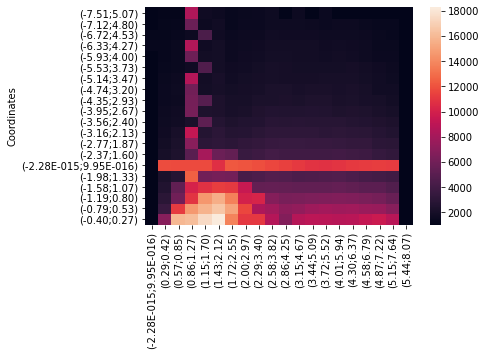

In [224]:
sbn.heatmap(mean_data, cmap="rocket").invert_yaxis()